## Trabalho de Conclusão de Semestre - Redes Neurais e Algoritmos Genéticos
<p align = 'center'> <h2> Predições Climáticas: </h2></p>
<p align = 'center'> <h3> O uso de Redes Neurais para análise da influência de temperatura na superfície marítma em locais de ocorrência do fenômeno 'El Niño'</h3> </p>

#### Autores:
Alice Kageyama (220049), Haziel Sixto Baden Sanchez Hermoza (220065), Monyque Karoline de Paula Silva (220063), Pedro Thomazelli Ferreira (220058)

<hr>

In [1]:
# Importações:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import MeanAbsolutePercentageError

# scikit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# captum
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

### Carregamento dos dados e pré-processamento

In [2]:
# Setup inicial:

TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 61455
ARQUIVO = 'dados/elnino.csv'

df = pd.read_csv(ARQUIVO, header=0)
df = df.drop(columns=['Observation', ' Date'])

# Removendo dados faltantes:
df = df[df != '.']
df.dropna(how='any', inplace=True)
df = df.astype(float)
df = df.reset_index(drop=True)

display(df)

,Year,Month,Day,Latitude,Longitude,Zonal Winds,Meridional Winds,Humidity,Air Temp,Sea Surface Temp
0,93.0,5.0,9.0,-0.02,-109.96,-2.1,2.1,81.2,26.80,27.02
1,93.0,5.0,10.0,-0.02,-109.96,-3.4,1.4,84.2,26.95,26.91
2,93.0,5.0,11.0,-0.02,-109.96,-3.8,2.2,84.9,26.98,26.78
3,93.0,5.0,12.0,-0.02,-109.96,-3.0,1.5,86.9,26.93,26.74
4,93.0,5.0,13.0,-0.02,-109.96,-4.5,1.9,87.6,27.01,26.82
...,...,...,...,...,...,...,...,...,...,...
93930,98.0,6.0,10.0,8.95,-140.33,-6.8,-5.3,81.3,27.52,28.17
93931,98.0,6.0,11.0,8.96,-140.33,-5.1,-0.4,94.1,26.04,28.14
93932,98.0,6.0,12.0,8.96,-140.32,-4.3,-3.3,93.2,25.80,27.87
93933,98.0,6.0,13.0,8.95,-140.34,-6.1,-4.8,81.3,27.17,27.93


In [3]:
# Definindo os dados de treino e teste:

FEATURES = [df.columns[0],df.columns[1],df.columns[2],df.columns[3],df.columns[4],df.columns[5],df.columns[6],df.columns[7],df.columns[8]]
TARGET = [df.columns[9]]

indices = df.index

indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

x_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGET, axis=1)
x_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGET, axis=1)

In [4]:
# Normalização:

normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(x_treino)
normalizador_y.fit(y_treino)

x_treino = normalizador_x.transform(x_treino)
y_treino = normalizador_y.transform(y_treino)
x_teste = normalizador_x.transform(x_teste)
y_teste = normalizador_y.transform(y_teste)

### Exploração dos dados

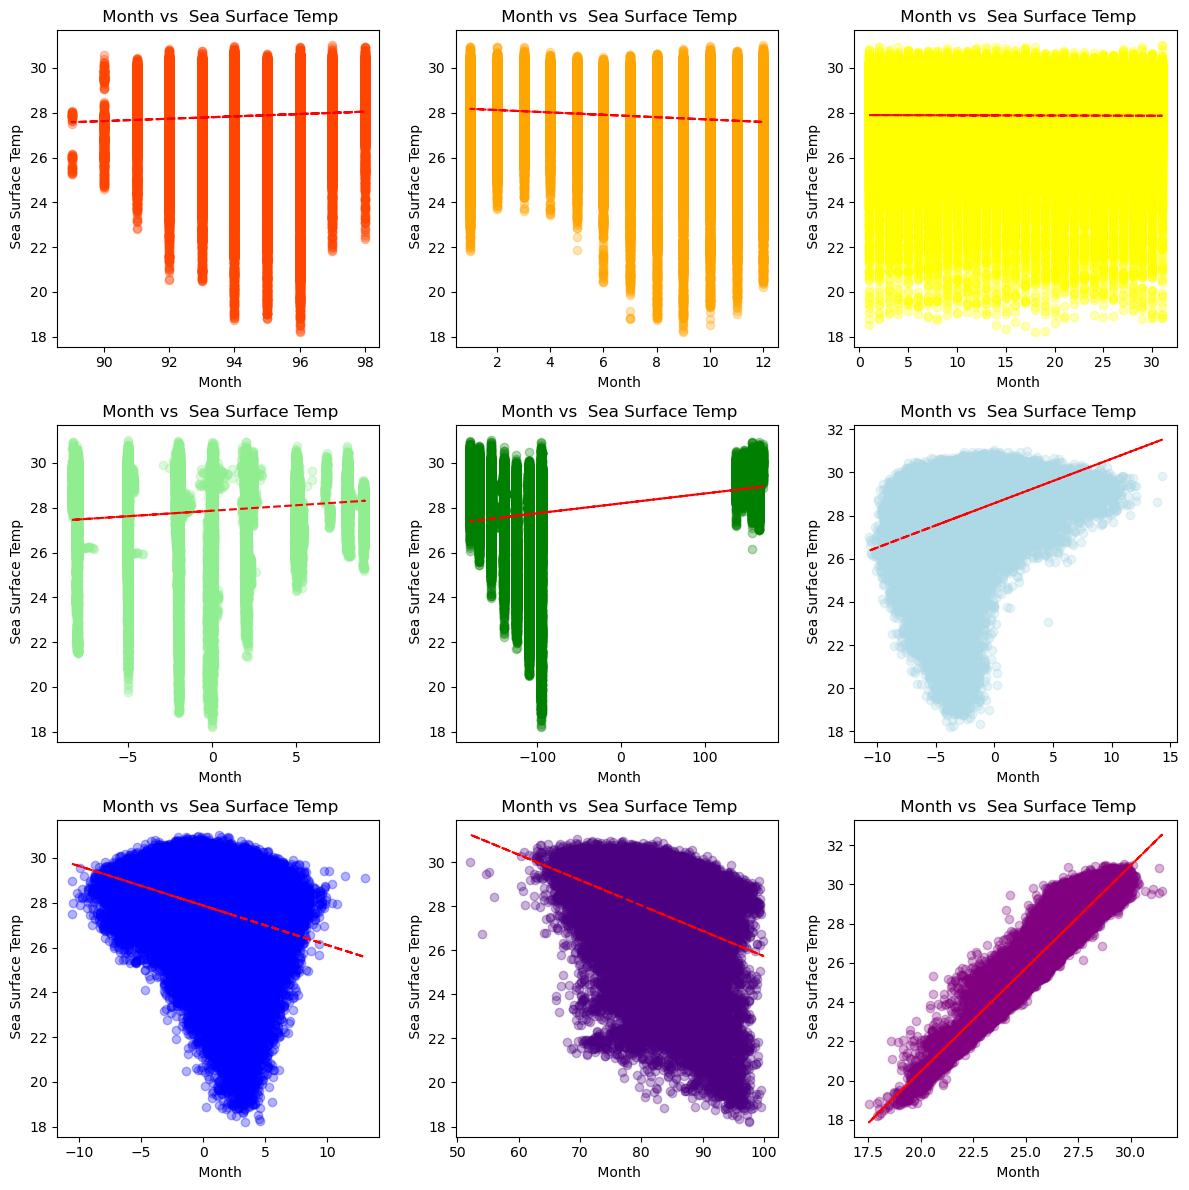

In [5]:
# Scatter plots para cada feature em relação ao target:

fig, axs = plt.subplots(3,3,figsize = (12,12))
axs = axs.flatten()
for (i, ax), cor in zip(enumerate(axs),['orangered', 'orange', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue', 'indigo', 'purple']):
    x = list(df[FEATURES[i]])
    y = list(df[TARGET[0]])
    
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)
    
    ax.scatter(x, y, color=cor, alpha=0.3)
    ax.plot(x, p(x), 'r--')
    
    ax.set_title(FEATURES[1] + ' vs ' + TARGET[0])
    ax.set_xlabel(FEATURES[1])
    ax.set_ylabel(TARGET[0])
    
plt.tight_layout()
plt.show()

In [6]:
# Matrizes de covariância e correlação:

df_covariancia = df.cov()
df_correlacao = df.corr()

print('Matriz de covariância:')
df_covariancia

Matriz de covariância:


,Year,Month,Day,Latitude,Longitude,Zonal Winds,Meridional Winds,Humidity,Air Temp,Sea Surface Temp
Year,3.704085,-1.248467,-0.279408,0.205109,-8.659407,0.173187,-0.494872,-0.119654,0.179682,0.193434
Month,-1.248467,12.133111,0.428200,-0.019492,-4.024826,0.752985,2.793133,-2.435041,-0.782476,-0.644322
Day,-0.279408,0.428200,77.384094,-0.068417,-2.273220,0.151603,0.150651,-0.011692,-0.109704,-0.079479
Latitude,0.205109,-0.019492,-0.068417,22.760447,59.358429,1.925653,-1.328616,3.979202,0.608119,1.117423
Longitude,-8.659407,-4.024826,-2.273220,59.358429,16571.923850,160.519202,-9.464515,-29.049808,53.684977,73.265995
Zonal Winds,0.173187,0.752985,0.151603,1.925653,160.519202,11.718364,0.824931,1.147670,1.336473,2.409589
Meridional Winds,-0.494872,2.793133,0.150651,-1.328616,-9.464515,0.824931,9.127821,1.237528,-1.716280,-1.611299
Humidity,-0.119654,-2.435041,-0.011692,3.979202,-29.049808,1.147670,1.237528,27.828425,-3.427850,-3.203019
Air Temp,0.179682,-0.782476,-0.109704,0.608119,53.684977,1.336473,-1.716280,-3.427850,2.803886,2.947269
Sea Surface Temp,0.193434,-0.644322,-0.079479,1.117423,73.265995,2.409589,-1.611299,-3.203019,2.947269,3.504357


In [7]:
print('Matriz de correlação:')
df_correlacao

Matriz de correlação:


,Year,Month,Day,Latitude,Longitude,Zonal Winds,Meridional Winds,Humidity,Air Temp,Sea Surface Temp
Year,1.000000,-0.186230,-0.016503,0.022339,-0.034951,0.026287,-0.085108,-0.011785,0.055755,0.053689
Month,-0.186230,1.000000,0.013974,-0.001173,-0.008976,0.063149,0.265413,-0.132518,-0.134154,-0.098813
Day,-0.016503,0.013974,1.000000,-0.001630,-0.002007,0.005034,0.005668,-0.000252,-0.007448,-0.004826
Latitude,0.022339,-0.001173,-0.001630,1.000000,0.096651,0.117911,-0.092178,0.158111,0.076123,0.125119
Longitude,-0.034951,-0.008976,-0.002007,0.096651,1.000000,0.364256,-0.024335,-0.042777,0.249050,0.304027
Zonal Winds,0.026287,0.063149,0.005034,0.117911,0.364256,1.000000,0.079763,0.063553,0.233156,0.376015
Meridional Winds,-0.085108,0.265413,0.005668,-0.092178,-0.024335,0.079763,1.000000,0.077647,-0.339254,-0.284897
Humidity,-0.011785,-0.132518,-0.000252,0.158111,-0.042777,0.063553,0.077647,1.000000,-0.388059,-0.324348
Air Temp,0.055755,-0.134154,-0.007448,0.076123,0.249050,0.233156,-0.339254,-0.388059,1.000000,0.940233
Sea Surface Temp,0.053689,-0.098813,-0.004826,0.125119,0.304027,0.376015,-0.284897,-0.324348,0.940233,1.000000


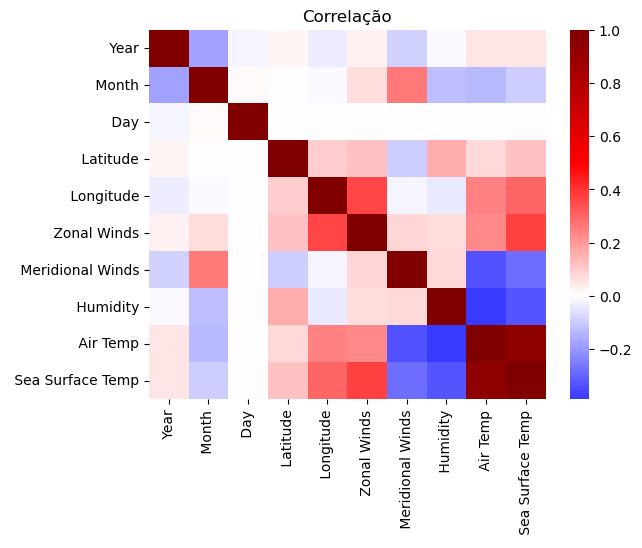

In [8]:
# Criando um mapa de cores dos valoes da correlação:

sns.heatmap(df_correlacao, 
        xticklabels=df_correlacao.columns,
        yticklabels=df_correlacao.columns,
           cmap='seismic',
           center = 0)

plt.title('Correlação')
plt.show()

### Tensorização dos dados de entrada

In [9]:
# Criando tensores:

x_treino = torch.tensor(x_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)
x_teste = torch.tensor(x_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [10]:
# Checando os dados:

print(x_treino)
print()
print(y_treino)

tensor([[0.4444, 1.0000, 0.3000,  ..., 0.4110, 0.6862, 0.7207],
        [0.8889, 0.4545, 0.1667,  ..., 0.5169, 0.6130, 0.8314],
        [0.7778, 0.9091, 0.0000,  ..., 0.4195, 0.6841, 0.4884],
        ...,
        [0.4444, 0.3636, 0.4333,  ..., 0.3856, 0.7301, 0.6780],
        [0.8889, 0.6364, 0.0000,  ..., 0.3051, 0.6025, 0.7359],
        [0.3333, 0.4545, 0.9000,  ..., 0.4831, 0.6506, 0.5810]])

tensor([[0.8132],
        [0.8444],
        [0.4786],
        ...,
        [0.7121],
        [0.8444],
        [0.5377]])


### Criação da classe da rede neural e definição de outros parâmetros

In [11]:
# Criando a classe da rede neural:

class OS_MENININHOS(nn.Module):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        super().__init__()

        # Definindo as camadas da rede:
        
        self.camadas = nn.Sequential(
                    nn.Linear(num_dados_entrada, neuronios_c1),
                    nn.ReLU(),
                    nn.Linear(neuronios_c1, neuronios_c2),
                    nn.ReLU(),
                    nn.Linear(neuronios_c2, num_targets),
                )

    def forward(self, x):
        """ Esse é o método que executa a rede do pytorch."""
        x = self.camadas(x)
        return x

In [12]:
# Criando uma instância da rede:

NUM_DADOS_DE_ENTRADA = x_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 150
NEURONIOS_C2 = 63

minha_redezinha = OS_MENININHOS(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NUM_DADOS_DE_SAIDA)

In [13]:
# Checando os parâmetros internos:

for p in minha_redezinha.parameters():
    print(p)

Parameter containing:
tensor([[-0.2148, -0.0561, -0.3113,  ...,  0.1231, -0.1898,  0.2463],
        [-0.0057,  0.1504,  0.2516,  ..., -0.0471,  0.3010,  0.0812],
        [-0.1300, -0.1042,  0.1699,  ..., -0.3038,  0.1930, -0.1639],
        ...,
        [-0.2822,  0.1614, -0.1473,  ...,  0.2014,  0.2551,  0.0608],
        [ 0.1457,  0.1359, -0.2890,  ..., -0.1368,  0.2013, -0.2718],
        [ 0.3200, -0.0822,  0.2162,  ..., -0.2448, -0.1943,  0.0662]],
       requires_grad=True)
Parameter containing:
tensor([-0.1665, -0.2231,  0.2067,  0.3192,  0.3160, -0.2517,  0.0554, -0.2599,
        -0.2631,  0.3277, -0.0250,  0.2570,  0.0751,  0.0116, -0.0296,  0.3184,
         0.1397,  0.0084,  0.2800,  0.1020, -0.3049, -0.1949, -0.3185,  0.0353,
         0.2659,  0.2093, -0.0481, -0.0507,  0.1504, -0.0274, -0.0429,  0.2892,
        -0.0903,  0.0011, -0.1686,  0.1687, -0.0099, -0.3180, -0.2739, -0.3084,
         0.1021, -0.1519,  0.0247,  0.3069, -0.1971, -0.2911, -0.0867, -0.1542,
         0.1591

In [14]:
# Primeiro teste de previsão (ruinzinha):

y_prev = minha_redezinha(x_treino)
y_prev

tensor([[0.0375],
        [0.0423],
        [0.0317],
        ...,
        [0.0522],
        [0.0011],
        [0.0033]], grad_fn=<AddmmBackward0>)

In [15]:
# Usando o otimizador (Adam):

TAXA_DE_APRENDIZADO = 0.001

# A função perda será o erro quadrático médio:
fn_perda = nn.MSELoss()

# O otimizador será o Adam, um tipo de descida do gradiente:
otimizador = optim.Adam(minha_redezinha.parameters(), lr=TAXA_DE_APRENDIZADO)

### Treino da rede neural:

In [16]:
# Treinando a rede:

# Colocando ela no "modo treino":
minha_redezinha.train()

NUM_EPOCAS = 1000

y_true = y_treino

for epoca in range(NUM_EPOCAS):
    # Forward pass:
    y_pred = minha_redezinha(x_treino)

    # Zero grad:
    otimizador.zero_grad()

    # Loss:
    loss = fn_perda(y_pred, y_true)

    # Backpropagation:
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    # Exibe o resultado:
    print(epoca, loss.data)

0 tensor(0.5585)
1 tensor(0.4539)
2 tensor(0.3625)
3 tensor(0.2838)
4 tensor(0.2163)
5 tensor(0.1593)
6 tensor(0.1125)
7 tensor(0.0756)
8 tensor(0.0483)
9 tensor(0.0304)
10 tensor(0.0215)
11 tensor(0.0211)
12 tensor(0.0274)
13 tensor(0.0369)
14 tensor(0.0458)
15 tensor(0.0516)
16 tensor(0.0536)
17 tensor(0.0520)
18 tensor(0.0477)
19 tensor(0.0420)
20 tensor(0.0359)
21 tensor(0.0302)
22 tensor(0.0256)
23 tensor(0.0222)
24 tensor(0.0202)
25 tensor(0.0193)
26 tensor(0.0194)
27 tensor(0.0199)
28 tensor(0.0208)
29 tensor(0.0217)
30 tensor(0.0225)
31 tensor(0.0230)
32 tensor(0.0232)
33 tensor(0.0231)
34 tensor(0.0227)
35 tensor(0.0220)
36 tensor(0.0211)
37 tensor(0.0202)
38 tensor(0.0192)
39 tensor(0.0183)
40 tensor(0.0175)
41 tensor(0.0169)
42 tensor(0.0165)
43 tensor(0.0162)
44 tensor(0.0161)
45 tensor(0.0161)
46 tensor(0.0160)
47 tensor(0.0160)
48 tensor(0.0159)
49 tensor(0.0157)
50 tensor(0.0154)
51 tensor(0.0150)
52 tensor(0.0145)
53 tensor(0.0140)
54 tensor(0.0135)
55 tensor(0.0130)
56

In [17]:
# Checando a performance da rede:

with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_redezinha(x_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

for yt, yp in zip(y_true, y_pred):
    print(yt, yp)

[28.63999986] [28.63450515]
[29.03999988] [29.8951584]
[24.33999998] [24.35187519]
[25.92] [26.36701371]
[26.95000037] [27.15836652]
[29.14999973] [29.46295222]
[23.66999987] [23.81837996]
[28.01000028] [26.89855814]
[26.70000035] [26.42358147]
[28.88999987] [29.29149574]
[28.77000017] [28.36744274]
[30.2999998] [29.89643978]
[29.23999989] [29.01909717]
[23.83000011] [23.79772961]
[29.38000005] [29.44155396]
[29.44999975] [28.3349172]
[29.78000008] [29.77292298]
[28.88999987] [28.90211825]
[28.39999969] [28.3861825]
[25.58999968] [26.9981231]
[29.63999992] [29.84412134]
[28.63000001] [28.83098729]
[30.33000011] [29.94445299]
[25.31999997] [25.62358219]
[27.32000008] [27.91431776]
[27.58999979] [27.05539705]
[29.14999973] [29.59448361]
[24.36000006] [24.84677189]
[28.73999986] [28.46968689]
[28.58000001] [28.77792284]
[27.78999981] [27.40296833]
[29.54999976] [29.83792888]
[29.3899999] [29.38638629]
[28.02999997] [28.42211485]
[25.87] [26.32520139]
[25.02999979] [25.13345104]
[26.110000

### Teste da rede

In [18]:
# Testando a rede:

# Colocando ela no "modo avaliação":
minha_redezinha.eval()

with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_teste)
    y_pred = minha_redezinha(x_teste)
    y_pred = normalizador_y.inverse_transform(y_pred)

for yt, yp in zip(y_true, y_pred):
    print(yt, yp)

[26.97000006] [27.04872742]
[28.32999999] [29.00051978]
[28.78999987] [28.45962118]
[29.61000037] [29.55560169]
[27.27999993] [27.43806124]
[23.80000018] [23.11118027]
[27.72999996] [27.88053841]
[28.88000002] [29.46270176]
[29.23000005] [27.85407741]
[25.86000015] [25.28314697]
[29.01000034] [28.42705121]
[30.2999998] [30.12291534]
[29.18999989] [29.30654836]
[29.14999973] [28.97901889]
[28.43999985] [27.9755653]
[29.47000021] [29.44460155]
[29.06000034] [29.05585289]
[28.93000003] [28.64057813]
[29.4399999] [29.36608329]
[29.2700002] [29.60735948]
[29.90999963] [29.66001723]
[30.25999965] [30.27782566]
[29.54999976] [29.21141424]
[28.17000014] [28.7030113]
[28.71000032] [28.69655307]
[28.13999983] [27.68149579]
[29.71000038] [28.82423494]
[29.74999977] [29.6361887]
[28.93000003] [29.10903912]
[24.41999991] [24.31302889]
[23.23999992] [24.36775462]
[28.03999982] [27.93575892]
[29.18999989] [28.98574749]
[29.53999991] [29.00260538]
[27.5700001] [26.96331205]
[26.57000004] [26.74031683]

In [19]:
# Medindo a performance com RMSE:

RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(f'Loss do teste: {RMSE}')

Loss do teste: 0.42392523130588644


In [20]:
# Medindo a performance com MAPE:
target = torch.tensor([1, 10, 1e6])
preds = torch.tensor([0.9, 15, 1.2e6])
MAPE = MeanAbsolutePercentageError()
print(f'Loss do teste: {MAPE(preds, target)}')

Loss do teste: 0.2666666805744171
